<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/demo_LowRankSparse_BackgroundSubtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background Subtraction by Low-rank and Sparse Modeling

In [1]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_reserved())
    torch.cuda.empty_cache()

Tesla T4
0
0


In [2]:
#@title ## Download and extract data zipfile
import zipfile
import os

root_dir = "/tmp/hall"
if not os.path.isdir(root_dir):
    !wget --no-check-certificate --show-progress -q\
        "https://www.dropbox.com/s/hof9g5af1964j8r/hall.zip?dl=1" \
        -O "/tmp/hall.zip"
    
    zip_filename = "/tmp/hall.zip"
    zip_ref = zipfile.ZipFile(zip_filename, 'r')
    zip_ref.extractall(root_dir)
    zip_ref.close()

imageseq_files = sorted(os.listdir(root_dir))

from PIL import Image
import numpy as np

im = np.array(Image.open(root_dir + '/' + imageseq_files[0]))
imageseq = []
for filename in imageseq_files:
    fullname = root_dir + '/' + filename
    if os.path.isfile(fullname):
        imageseq.append(np.array(Image.open(fullname).convert('L')))

imageseq = np.array(imageseq)
print(imageseq.shape)


# Matrix shape
frames_begin, frames_end = 0, 100
nframes = frames_end - frames_begin
DDseq = imageseq[frames_begin:frames_end,:,:].copy().astype(float) / 255.
DDseq_t = imageseq[-nframes:,:,:].copy().astype(float) / 255.

DD = DDseq.reshape(nframes,imageseq.shape[1]*imageseq.shape[2]).T
DD_t = DDseq_t.reshape(nframes,imageseq.shape[1]*imageseq.shape[2]).T

print(DD.shape)
print(DD.min(), DD.max())

m, n = imageseq.shape[1:]

/tmp/hall.zip       100%[===================>] 221.02M  46.6MB/s    in 4.3s    
(3584, 144, 176)
(25344, 100)
0.0 1.0


In [3]:
#@title ## Frame differences (for comparison)
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

def anim_make(MM, hw, vmin=0, vmax=1,interval=50):
    fig = plt.figure(figsize=(hw[1]/33*len(MM),hw[0]/33))
    ims = []
    for i in range(MM[0].shape[1]):
        V = []
        for l in range(len(MM)):
            V.append(MM[l][:,i].reshape(hw))
        #ims.append( [plt.imshow(np.abs(M[:,i]).reshape(hw), cmap='gray', vmin=vmin, vmax=vmax)] )
        ims.append( [plt.imshow(np.abs(np.hstack(V)), cmap='gray', vmin=vmin, vmax=vmax)] )
    anim = animation.ArtistAnimation(fig, ims, interval=interval, repeat=False, blit=True)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
    plt.close(anim._fig)
    return anim

print("Figure 1:  Original (DD[:,:-1]),  frame differential (Subt=DD[:,:-1]-DD[:,1:]),  background (DD[:,:-1]-Subt) ?")

Subt = DD[:,:-1]-DD[:,1:]
DLDiffanim = anim_make([  DD[:,:-1],  Subt,  DD[:,:-1]-Subt  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLDiffanim.to_html5_video())

Figure 1:  Original (DD[:,:-1]),  frame differential (Subt=DD[:,:-1]-DD[:,1:]),  background (DD[:,:-1]-Subt) ?


$\textrm{Minimize}_{(L,S)}\|L\|_* + \lambda \|S\|_1$ subject to $D=L+S$

[ 10/100]: loss = 1689.3148,  
[ 20/100]: loss = 1588.4702,  
[ 30/100]: loss = 1552.8248,  
[ 40/100]: loss = 1534.4456,  
[ 50/100]: loss = 1523.2850,  
[ 60/100]: loss = 1516.2926,  
[ 70/100]: loss = 1512.0259,  
[ 80/100]: loss = 1509.6140,  
[ 90/100]: loss = 1508.1296,  
[100/100]: loss = 1507.1885,  
5675.9092807769775  [ms]
Figure 2:  Original,  foreground (Sparse),  background (Low-rank) !


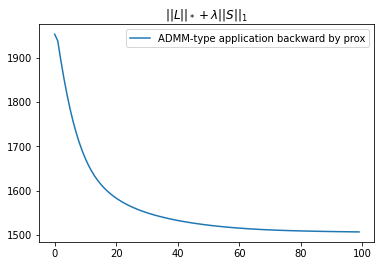

In [4]:
#@title # Now, enjoy the power of mathematics by low-rank and sparse modeling!


### Definitions

soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

def svt(input, th):
    u, s, v = torch.svd(input)
    return torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,th))), torch.transpose(v, -2, -1)), u, s, v


### Algorithm
from time import time

D = torch.from_numpy(DD.astype(np.float32)).to(device)

# Hyperparameters
rcp_rho = 1./ 1.
m, n = D.shape[0], D.shape[1]
ls = 1./np.sqrt(max(m,n))


# Using L1Loss with prox
nucloss =lambda x:  torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x))

S, U  = 0, 0

t = time()
num_iter = 100
display_step = num_iter // 10
history_loss = []

for iter in range(num_iter):

    with torch.no_grad():
        L = svt(D - S - U, rcp_rho)[0]
        S = soft(D - L - U, ls*rcp_rho)
        U = U + L + S - D
        objJ = nucloss(L) + ls * l1loss(S)

    history_loss.append(objJ.item())
    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, objJ))

print((time()-t)*1000, ' [ms]')


### Results
import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||S||_1$")
plt.plot(history_loss, label="ADMM-type application backward by prox")
plt.legend()

print("Figure 2:  Original,  foreground (Sparse),  background (Low-rank) !")

DLSanim = anim_make([  DD,  S.cpu().data.numpy(),  L.cpu().data.numpy()  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLSanim.to_html5_video())